## Understand and process the raw data from InnovaDatabase 
### Remove columns with duplicate information or too many nulls; Remove duplicate data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re

In [183]:
import streamlit as st

!streamlit run app.py

^C


In [ ]:
df_excel = pd.read_excel('protein_beverages_and_sport_drinks.xls', sheet_name = 'Innova', dtype={'Product Id':str})

In [ ]:
df_excel.info()

In [ ]:
df_raw = df_excel.drop(columns=['S.No.', 'Produced in','Product Base','Alcohol By Volume','US Price','Us Price/Count','Category',
                                'Ingredient searched','Product Comments','Texture','Online Store','Manufactured by','Format',
                                'View Details','Whole Packweight(kg/ltr)','Whole Packweight(g/ml)','Protein (g per 100g)',
                                 'Pack Weight(kg/ltr)','US Price/Pound','Quantity','Company Country','Distributed In'])

In [ ]:
df_raw.info()

In [ ]:
raw_data = df_raw.drop_duplicates(subset = ['Product Id','Company','Product Name'])

In [ ]:
import dill
with open('raw_data.pkd', 'wb') as r:
    dill.dump(raw_data, r)

In [3]:
import dill
with open('raw_data.pkd', 'rb') as r:
    data_raw = dill.load(r)

In [ ]:
data_raw.info()

### Remove 'fake' New Products
Product 'event', such as "import", "shelf snapshots", and "new package", are not really New Product Launch, which are removed from the dataset.

In [ ]:
data_raw['Event'].value_counts()

In [4]:
new_product_data = data_raw[(data_raw['Event'] == 'New Product') | (data_raw['Event'] == 'Reformulation')]
new_product_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11443 entries, 0 to 19239
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product Id               11443 non-null  object 
 1   Company                  11443 non-null  object 
 2   Event Date               11443 non-null  object 
 3   Event                    11443 non-null  object 
 4   Subcategory              11443 non-null  object 
 5   Private Label            11443 non-null  object 
 6   Region                   11443 non-null  object 
 7   Country                  11443 non-null  object 
 8   Brand                    11443 non-null  object 
 9   Product Name             11443 non-null  object 
 10  Description              11443 non-null  object 
 11  Claims/Features          11440 non-null  object 
 12  Extra Notes              10137 non-null  object 
 13  Positioning Category     11442 non-null  object 
 14  Positioning Subcategory  11

#### Filter out the "fake" vegan products -- Not implemented

In [ ]:
alarm_words = ['whey', 'milk protein', 'milk powder', 'milk concentrate', 'skimmed milk', 'skim milk', 'powdered milk',
               'powder milk', 'cow milk', 'casein', 'caseinate', 'condensed milk']
# example_token = 'skim milk protein(from cow milk)'

def fake_vegan(tokens):
    for token in tokens:
        for w in alarm_words:
            if w in token:
                return True
                break
    return False

ingredients = data_raw['Ingredients'].str.lower().str.split(',')


### Build tokenizers to fit the patterns of different text

Remove ingredients that are flavors, colors, acidity regulators, sweeteners, preservatives, vitamins, minerals, etc, which don't necessarily contribute to the claims of 'dairy alternative' or 'plant based', but at the same time, may occur at a high frequency and impact analysis.

In [5]:
import re

# positioning tokenizer
def positioning_tokenizer(text):
    return [t.strip() for t in text.split(',')]

In [5]:
ingredient_stop_words = ['flavor', 'color', 'acid', 'sweetener', 'freshness', 'preservative', 'other ingredient', 'less than',
                  'mineral', 'antioxidant']

# ingredients tokenizer
def splitter_cleaner(line):
    parens = 0
    low = 0
    high = 0
    out = []
    
    for i, c in enumerate(line):
        if c == '(':
            parens += 1
        elif c == ')':
            parens -= 1
            if parens < 0:
                parens = 0
        elif (c == ',' or c =='.') and parens == 0:
            high = i
            word = line[low:high].strip().lower()
            boo = False
            for w in ingredient_stop_words:
                if w in word:
                    boo = boo or True
            if word!= None and (not boo):
                out.append(word)
            low = i + 1
    
    return out

In [ ]:
text = 'BCAA (leucine, isoleucine, valine), beta-alanine, arginine-alpha-ketoglutarate, citrulline malate, flavors, taurine,tyrosine, anti-caking agent (silica), caffeine anhydrous, acid (citric acid), sweetener (sucralose), grape skin extract, color (beetroot red), emulsifier (sunflower lecithin), vitamin B6 (pyridoxine hydrochloride).'
print(text)
print()
print(splitter_cleaner(text))

## The most common market positioning:
1. The most common products positioning globally
2. The most common products positioning in US
3. Top 20 manufacturers by numbers of new products launched
4. The most common products positioning by major players

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

positioning_countvec = CountVectorizer(tokenizer = positioning_tokenizer,
                                    token_pattern = None,)

#### The top 10 positioning categories globally

In [ ]:
global_data = new_product_data['Positioning Subcategory'].astype(str)
global_fit = positioning_countvec.fit_transform(global_data)

categories = positioning_countvec.get_feature_names_out()
counts = np.array(np.sum(global_fit, axis=0))

positioning_global = pd.DataFrame(zip(categories, counts[0]))
positioning_global.columns = ['category', 'count']
positioning_global['frequency'] = positioning_global['count'] / positioning_global['count'].sum()

In [ ]:
positioning_global.sort_values(by = 'frequency', ascending = False)[:10]

#### The top 10 positioning categories in US

In [ ]:
US_data = new_product_data[new_product_data['Country'] == 'United States']['Positioning Subcategory'].astype(str)
US_fit = positioning_countvec.fit_transform(US_data)

categories = positioning_countvec.get_feature_names_out()
counts = np.array(np.sum(US_fit, axis=0))

positioning_US = pd.DataFrame(zip(categories, counts[0]))
positioning_US.columns = ['category', 'count']
positioning_US['frequency'] = positioning_US['count'] / positioning_US['count'].sum()

In [ ]:
positioning_US.sort_values(by = 'frequency', ascending = False)[:10]

#### Top 20 manufacturers by numbers of new products launched

In [95]:
new_product_data['Company'].value_counts()[:20]

Company
Prozis                      617
The Protein Works           444
Bulk                        388
Alpro                       336
Foodspring                  134
Danone                      104
Biotechusa                   94
The Hain Celestial Group     94
Bright Lifecare              89
Cnp Professional             87
Coca Cola                    83
Nu3                          80
Mewell                       76
Nutrabio Labs                72
Phd Nutrition                64
Myprotein                    63
Sinob                        59
Scitec Nutrition             59
Fitmart                      58
Body And Fit                 57
Name: count, dtype: int64

#### The most common products positioning by major players

In [ ]:
Danone_data = new_product_data[new_product_data['Company'] == 'Danone']['Positioning Subcategory'].astype(str)
Danone_fit = positioning_countvec.fit_transform(Danone_data)

categories = positioning_countvec.get_feature_names_out()
counts = np.array(np.sum(Danone_fit, axis=0))

positioning_Danone = pd.DataFrame(zip(categories, counts[0]))
positioning_Danone.columns = ['category', 'count']
positioning_Danone['frequency'] = positioning_Danone['count'] / positioning_Danone['count'].sum()

In [ ]:
positioning_Danone.sort_values(by = 'frequency', ascending = False)[:10]

## Topic Modeling by LDA Method

In [7]:
#Using gensim can extract more information about the resulting generative model than using scikit-learn's LDA class
import gensim

In [8]:
product_features = new_product_data[['Claims/Features']].astype('string').dropna()
product_features.info()
feature_text = product_features['Claims/Features'].values.tolist()

<class 'pandas.core.frame.DataFrame'>
Index: 11440 entries, 0 to 19239
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Claims/Features  11440 non-null  string
dtypes: string(1)
memory usage: 178.8 KB


In [13]:
# Stop_Words = stopwords.difference({'no','free'}) # remove 'no' and 'free' from the stopwords
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])
stopwords = spacy.lang.en.stop_words.STOP_WORDS                     
#stopwords = stopwords.difference({'he','his','her','hers'}) # Removing a few words that don't lemmatize well
stopwords.update(['v', 'l', 'mg', 'base', 'add', 'serve', 'beta', 'contain', '.',
                 'd', 'll', 'm', 'n', 's', 've', '‘t', '’t', 't', ':']) # Customize the stopwords

def process_words(text, stop_words=set()):
    result = []
    for t in text:
        doc = ' '.join(re.findall(r'\b\D[a-zA-Z\'\/]*\b', t))
        result.append([token.lemma_.lower() for token in nlp(doc) if token.lemma_ not in stop_words])
        #result.append([token for token in tokens if token not in stop_words])
    return result

processed_text = process_words(feature_text, stop_words=stopwords.union(['-PRON-','serving','levels','suitable',
                                                                         '-', ' ','  ','   ','ingredient','product']))

In [14]:
dictionary = gensim.corpora.Dictionary(processed_text)
print(f'Number of unique tokens: {len(dictionary)}')
corpus = [dictionary.doc2bow(t) for t in processed_text]

Number of unique tokens: 9004


#### Find the dominant features of new products launched Globally
#### After the analysis and manually checking the topics, it seems that 3 is the right number of topics

In [ ]:
# Use the coherence score provided by the gensim package to optimize the number of topics
#coherence is supposed to model "human interpretability" of topics

coherence_scores = []
for n in range(3, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

In [ ]:
coherence_scores

In [97]:
lda_model_3 = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=3, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

In [98]:
from pprint import pprint

pprint(lda_model_3.print_topics(num_words=15))

[(0,
  '0.094*"protein" + 0.020*"high" + 0.019*"muscle" + 0.018*"whey" + '
  '0.017*"amino" + 0.016*"acid" + 0.015*"vegan" + 0.012*"vegetarian" + '
  '0.012*"sugar" + 0.011*"quality" + 0.010*"bcaa" + 0.010*"flavor" + '
  '0.010*"mass" + 0.009*"low" + 0.009*"source"'),
 (1,
  '0.031*"certify" + 0.031*"plant" + 0.029*"sugar" + 0.025*"organic" + '
  '0.025*"gluten" + 0.020*"lactose" + 0.018*"vegan" + 0.018*"dairy" + '
  '0.017*"vitamin" + 0.017*"certified" + 0.017*"calcium" + 0.016*"naturally" + '
  '0.016*"recyclable" + 0.015*"source" + 0.013*"soy"'),
 (2,
  '0.029*"muscle" + 0.015*"energy" + 0.012*"help" + 0.011*"body" + '
  '0.011*"normal" + 0.010*"support" + 0.010*"increase" + 0.010*"recovery" + '
  '0.009*"performance" + 0.009*"caffeine" + 0.009*"acid" + 0.009*"contribute" '
  '+ 0.008*"bcaa" + 0.008*"vitamin" + 0.007*"fatigue"')]


In [17]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        #keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text')],axis=1) 
                           #pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [99]:
main_topic_df = get_main_topic_df(lda_model_3, corpus, processed_text)

In [ ]:
main_topic_df.info()

In [ ]:
product_features.info()

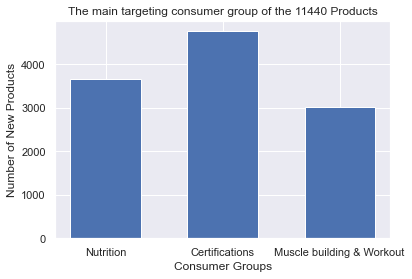

In [103]:
# plot_df = pd.DataFrame({'count': grouped_topics.count()['Processed_text'].to_list()}, index=)
plt.bar(['Nutrition','Certifications','Muscle building & Workout'], grouped_topics.count()['Processed_text'].to_list(), width=0.6)
plt.title(f'The main targeting consumer group of the {len(feature_text)} Products')
plt.ylabel('Number of New Products')
plt.xlabel('Consumer Groups')
plt.savefig('global_plot.png')

In [119]:
lda_top_words_index = set()
for i in range(lda_model_3.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model_3.get_topic_terms(i)])
    
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Consumer groups'] = main_topic_df['Dominant_topic']
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 0, 'Consumer groups'] = 'Nutrition'
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 1, 'Consumer groups'] = 'Certifications'
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 2, 'Consumer groups'] = 'Muscle building & Workout'

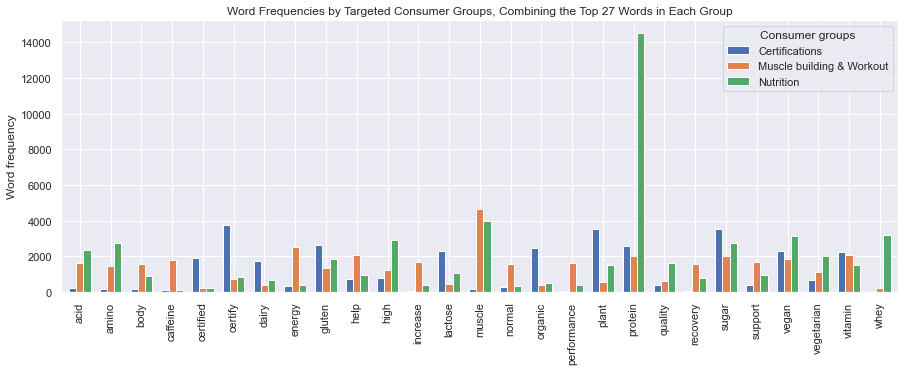

In [139]:
fig = lda_top_words_df.groupby('Consumer groups').sum().transpose().\
         plot(kind='bar', figsize=(15, 5), width=0.7)
fig.set_ylabel('Word frequency')
fig.set_title(f'Word Frequencies by Targeted Consumer Groups, Combining the Top {len(lda_top_words_index)} Words in Each Group')
figure = fig.get_figure()

figure.savefig('global_words.png')

In [20]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [21]:
vis_3_topics = pyLDAvis.gensim_models.prepare(lda_model_3, corpus, dictionary = lda_model_3.id2word)

In [ ]:
vis_3_topics

#### Find the dominant features of new products launched in NA region

In [59]:
NA_product_features = new_product_data[new_product_data['Region'] == 'North America']['Claims/Features'].dropna().astype(str)

In [60]:
NA_product_features.head()

28    USDA organic. Non-GMO Project verified. Dairy ...
31    USDA organic. Non-GMO Project verified. Dairy ...
36    Plant-based. Blender free. Made with peanuts a...
37    USDA organic. Unsweetened. Soy free. Suitable ...
38    USDA organic. Unsweetened. Soy free. Suitable ...
Name: Claims/Features, dtype: object

In [61]:
NA_feature_text = NA_product_features.values.tolist()
NA_processed_text = process_words(NA_feature_text, stop_words=stopwords.union(['-PRON-','contain','serving','levels','suitable', '-', ' ','  ','   ',
                                                                         'ingredient','product']))

In [62]:
NA_dictionary = gensim.corpora.Dictionary(NA_processed_text)
print(f'Number of unique tokens: {len(NA_dictionary)}')
NA_corpus = [NA_dictionary.doc2bow(t) for t in NA_processed_text]

Number of unique tokens: 5202


In [70]:
NA_coherence_scores = []
for n in range(2, 10):
    mod = gensim.models.ldamodel.LdaModel(corpus=NA_corpus, 
                                          id2word=NA_dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=NA_processed_text,
                                                 dictionary=NA_dictionary)
    NA_coherence_scores.append((n, cmodel.get_coherence()))

In [71]:
NA_coherence_scores

[(2, 0.5109118599213257),
 (3, 0.4553716603302574),
 (4, 0.4374198285107608),
 (5, 0.5250105393467447),
 (6, 0.492542234536133),
 (7, 0.4853062430145516),
 (8, 0.5101406318678322),
 (9, 0.5313458016476968)]

In [145]:
NA_lda_2 = gensim.models.ldamodel.LdaModel(corpus=NA_corpus, 
                                            id2word=NA_dictionary,
                                            num_topics=2, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(NA_lda_2.print_topics(num_words=20))

[(0,
  '0.036*"protein" + 0.022*"gluten" + 0.020*"plant" + 0.020*"organic" + '
  '0.017*"dairy" + 0.017*"sugar" + 0.017*"non" + 0.017*"flavor" + '
  '0.015*"vegan" + 0.013*"-gmo" + 0.013*"certify" + 0.013*"soy" + '
  '0.013*"artificial" + 0.012*"certified" + 0.011*"source" + 0.010*"natural" + '
  '0.010*"kosher" + 0.009*"calorie" + 0.009*"vegans" + 0.008*"vitamin"'),
 (1,
  '0.028*"muscle" + 0.013*"increase" + 0.012*"support" + 0.012*"help" + '
  '0.012*"protein" + 0.011*"energy" + 0.011*"bcaa" + 0.010*"acid" + '
  '0.010*"recovery" + 0.010*"body" + 0.010*"amino" + 0.008*"vegan" + '
  '0.007*"level" + 0.007*"improve" + 0.007*"performance" + 0.007*"blood" + '
  '0.007*"flavor" + 0.006*"gluten" + 0.006*"natural" + 0.006*"growth"')]


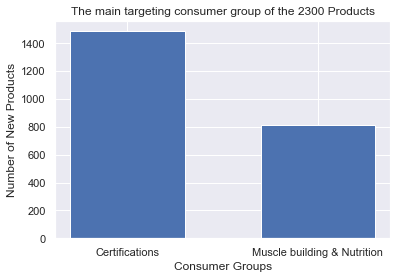

In [90]:
NA_main_topic = get_main_topic_df(NA_lda_2, NA_corpus, NA_processed_text)

NA_topics = NA_main_topic.groupby('Dominant_topic')
plt.bar(['Certifications','Muscle building & Nutrition'], NA_topics.count()['Processed_text'].to_list(), width=0.6)
plt.title(f'The main targeting consumer group of the {len(NA_feature_text)} Products')
plt.ylabel('Number of New Products')
plt.xlabel('Consumer Groups')
plt.savefig('NA_plot.png')

In [143]:
NA_top_words_index = set()
for i in range(NA_lda_2.num_topics):
    NA_top_words_index = NA_top_words_index.union([k for (k,v) in NA_lda_2.get_topic_terms(i)])
    
NA_words = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in NA_top_words_index} 
                       for lst in NA_corpus]

NA_top_words_df = pd.DataFrame(NA_words).fillna(0).astype(int).sort_index(axis=1)
NA_top_words_df['Consumer groups'] = NA_main_topic['Dominant_topic']
NA_top_words_df.loc[NA_top_words_df['Consumer groups'] == 0, 'Consumer groups'] = 'Certifications'
NA_top_words_df.loc[NA_top_words_df['Consumer groups'] == 1, 'Consumer groups'] = 'Muscle building & Nutrition'

In [144]:
NA_top_words_df.head(10)

,-base,bcaa,come,contribute,d,dot,environment,flax,health,inulin,lid,light,muscle,nutrition,office,popular,reduce,renewable,workout,Consumer groups
0,1,0,2,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,Certifications
1,1,0,2,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,Certifications
2,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,1,1,0,Certifications
3,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,Certifications
4,0,0,1,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,Certifications
5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,Certifications
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,Certifications
7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,Certifications
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,Certifications
9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,Certifications


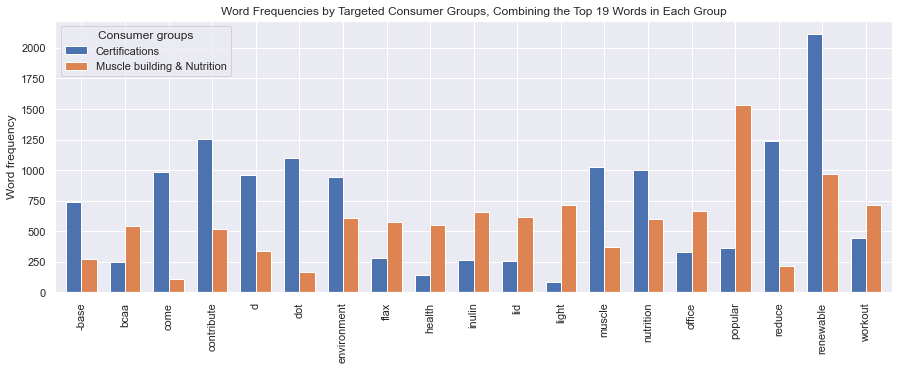

In [141]:
fig = NA_top_words_df.groupby('Consumer groups').sum().transpose().\
         plot(kind='bar', figsize=(15, 5), width=0.7)
fig.set_ylabel('Word frequency')
fig.set_title(f'Word Frequencies by Targeted Consumer Groups, Combining the Top {len(NA_top_words_index)} Words in Each Group')
figure = fig.get_figure()

figure.savefig('NA_words.png')

In [79]:
NA_2_topics = pyLDAvis.gensim_models.prepare(NA_lda_2, NA_corpus, dictionary = NA_lda_2.id2word)

In [ ]:
NA_2_topics

#### Find the dominant features of new products launched in Europe

In [34]:
EU_product_features = new_product_data[(new_product_data['Region'] == 'West Europe') | \
                        (new_product_data['Region'] == 'East Europe')]['Claims/Features'].dropna().astype(str)

In [35]:
EU_product_features.info()

<class 'pandas.core.series.Series'>
Index: 6347 entries, 0 to 19228
Series name: Claims/Features
Non-Null Count  Dtype 
--------------  ----- 
6347 non-null   object
dtypes: object(1)
memory usage: 99.2+ KB


In [36]:
EU_feature_text = EU_product_features.values.tolist()
EU_processed_text = process_words(EU_feature_text, stop_words=stopwords.union(['-PRON-','contain','serving','levels','suitable', '-', ' ','  ','   ',
                                                                         'ingredient','product']))

In [37]:
EU_dictionary = gensim.corpora.Dictionary(EU_processed_text)
print(f'Number of unique tokens: {len(EU_dictionary)}')
EU_corpus = [EU_dictionary.doc2bow(t) for t in EU_processed_text]

Number of unique tokens: 5493


In [81]:
EU_coherence_scores = []
for n in range(2, 10):
    mod = gensim.models.ldamodel.LdaModel(corpus=EU_corpus, 
                                          id2word=EU_dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=EU_processed_text,
                                                 dictionary=EU_dictionary)
    EU_coherence_scores.append((n, cmodel.get_coherence()))

In [82]:
EU_coherence_scores

[(2, 0.4578572431462126),
 (3, 0.5231300561062374),
 (4, 0.4955660971972499),
 (5, 0.4861231526524736),
 (6, 0.4586655539626206),
 (7, 0.5158026278896538),
 (8, 0.4857720085890854),
 (9, 0.49795325458785783)]

In [88]:
EU_lda_3 = gensim.models.ldamodel.LdaModel(corpus=EU_corpus, 
                                            id2word=EU_dictionary,
                                            num_topics=3, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(EU_lda_3.print_topics(num_words=20))

[(0,
  '0.038*"sugar" + 0.035*"certify" + 0.033*"plant" + 0.027*"lactose" + '
  '0.024*"vegan" + 0.023*"gluten" + 0.022*"organic" + 0.020*"naturally" + '
  '0.019*"low" + 0.017*"vitamin" + 0.017*"certified" + 0.017*"fsc" + '
  '0.016*"source" + 0.016*"recyclable" + 0.015*"fat" + 0.015*"-base" + '
  '0.015*"calcium" + 0.014*"protein" + 0.014*"vegans" + 0.012*"green"'),
 (1,
  '0.080*"protein" + 0.020*"muscle" + 0.020*"high" + 0.018*"amino" + '
  '0.017*"acid" + 0.016*"whey" + 0.013*"vegetarian" + 0.013*"vegan" + '
  '0.011*"bcaa" + 0.011*"mass" + 0.011*"quality" + 0.010*"diet" + '
  '0.009*"flavor" + 0.009*"use" + 0.008*"powder" + 0.008*"shake" + '
  '0.008*"sugar" + 0.007*"low" + 0.007*"premium" + 0.007*"blend"'),
 (2,
  '0.024*"muscle" + 0.023*"normal" + 0.020*"vitamin" + 0.019*"contribute" + '
  '0.016*"energy" + 0.015*"caffeine" + 0.013*"fatigue" + 0.012*"metabolism" + '
  '0.011*"performance" + 0.010*"function" + 0.009*"help" + 0.009*"sugar" + '
  '0.009*"body" + 0.008*"high" + 0.0

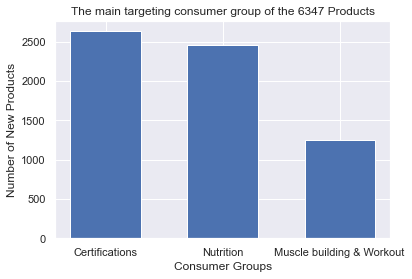

In [156]:
EU_main_topic = get_main_topic_df(EU_lda_3, EU_corpus, EU_processed_text)

EU_topics = EU_main_topic.groupby('Dominant_topic')
plt.bar(['Certifications','Nutrition','Muscle building & Workout'], EU_topics.count()['Processed_text'].to_list(), width=0.6)
plt.title(f'The main targeting consumer group of the {len(EU_feature_text)} Products')
plt.ylabel('Number of New Products')
plt.xlabel('Consumer Groups')
plt.savefig('EU_plot.png')

In [157]:
EU_top_words_index = set()
for i in range(EU_lda_3.num_topics):
    EU_top_words_index = EU_top_words_index.union([k for (k,v) in EU_lda_3.get_topic_terms(i)])
    
EU_words = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in EU_top_words_index} 
                       for lst in EU_corpus]

EU_top_words_df = pd.DataFrame(EU_words).fillna(0).astype(int).sort_index(axis=1)
EU_top_words_df['Consumer groups'] = EU_main_topic['Dominant_topic']
EU_top_words_df.loc[EU_top_words_df['Consumer groups'] == 0, 'Consumer groups'] = 'Certifications'
EU_top_words_df.loc[EU_top_words_df['Consumer groups'] == 1, 'Consumer groups'] = 'Nutrition'
EU_top_words_df.loc[EU_top_words_df['Consumer groups'] == 2, 'Consumer groups'] = 'Muscle building & Workout'

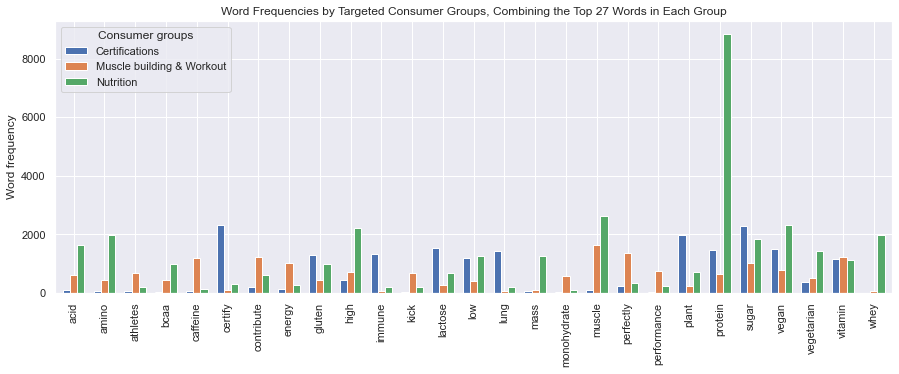

In [159]:
fig = EU_top_words_df.groupby('Consumer groups').sum().transpose().\
         plot(kind='bar', figsize=(15, 5), width=0.7)
fig.set_ylabel('Word frequency')
fig.set_title(f'Word Frequencies by Targeted Consumer Groups, Combining the Top {len(EU_top_words_index)} Words in Each Group')
figure = fig.get_figure()

figure.savefig('EU_words.png')

In [84]:
EU_3_topics = pyLDAvis.gensim_models.prepare(EU_lda_3, EU_corpus, dictionary = EU_lda_3.id2word)

In [ ]:
EU_3_topics

## Most Common Ingredients Used for Each Group of Products with the Same Features

In [161]:
# Build the dataframe
df = main_topic_df[['Dominant_topic', 'Percent']]
features_ingredients = df.rename(columns = {'Dominant_topic': 'dominant_feature', 'Percent': 'per_domination'})
features_ingredients['ingredients'] = new_product_data.dropna(subset=['Claims/Features'])['Ingredients'].astype('string') \
                                        .reset_index(drop = True)  # need to drop index from the 'Ingredients' column, otherwise data is lost
final_df = features_ingredients.dropna()

In [162]:
final_df.head()

,dominant_feature,per_domination,ingredients
1,2,0.814,"BCAA (leucine, isoleucine, valine), beta-alani..."
2,0,0.984,"Whey protein hydrolysate (milk), flavors, acid..."
3,2,0.952,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."
4,2,0.951,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."
5,2,0.951,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."


In [163]:
ingredient_stop_words = ['flavor', 'color', 'acid', 'sweetener', 'sugar', 'freshness', 'preservative', 'other ingredient', 
                         'less than', 'mineral', 'antioxidant', 'salt', 'water', 'sodium chloride', '5%',
                         'sucrose', 'sucralose', 'acesulfame', 'fructose', 'stevia', 'monk fruit']

def has_numbers(string):                           # a function to determine if the ingredient token has numbers
    return any(char.isdigit() for char in string)

# Build ingredients tokenizer + token cleaner
def splitter_cleaner(line):
    parens = 0
    low = 0
    high = 0
    out = []
    
    for i, c in enumerate(line):
        if c == '(':
            parens += 1
        elif c == ')':
            parens -= 1
            if parens < 0:
                parens = 0
        elif (c == ',' or c =='.') and parens == 0:
            high = i
            word = line[low:high].strip().lower()
            in_stopwords = False
            for w in ingredient_stop_words:
                if w in word:
                    in_stopwords = in_stopwords or True
            if word!= None and (not in_stopwords) and (not has_numbers(word)):       
                if word.startswith('l-'):            # remove 'l-' from 'l-amino acid'
                    word = word[2:]                        
                    out.append(word)
                elif word.startswith('organic '):        # remove 'organic' from 'organic (ingredient)'
                    word = word[8:] 
                    out.append(word)
                elif word.endswith(' (bcaa)'):        # remove '(bcaa)' from 'amino aicd (bcaa)'
                    word = word[:-7] 
                    out.append(word)
                elif word.startswith('emulsifier ('):        # remove 'emulsifier ()' from 'emulsifier (...)'
                    word = word[12:-1] 
                    out.append(word)
                elif word.startswith('emulsifier: '):
                    word = word[12:] 
                    out.append(word)
                elif word.startswith('stabilizer ('):        # remove 'stabilizer ()' from 'stabilizer (...)'
                    word = word[12:-1] 
                    out.append(word)
                elif word.startswith('stabilizer: '):
                    word = word[12:] 
                    out.append(word)
                elif word.startswith('thickener ('):        # remove 'thickener ()' from 'thickener (...)'
                    word = word[11:-1] 
                    out.append(word)    
                elif word == 'pea protein isolate':        # combine the count of 'pea protein' and 'pea protein isolate'
                    word = 'pea protein'
                    out.append(word)    
                out.append(word)
            low = i + 1
    
    return out

In [164]:
vectorizer = CountVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,)

In [165]:
ingredients_vec = vectorizer.fit_transform(final_df['ingredients'])

ingredients = vectorizer.get_feature_names_out()
counts = np.array(np.sum(ingredients_vec, axis=0))

ingredients_df = pd.DataFrame(zip(ingredients, counts[0]))
ingredients_df.columns = ['ingredient', 'count']
ingredients_df['frequency'] = ingredients_df['count'] / ingredients_df['count'].sum()

In [55]:
ingredients_df.sort_values(by = 'frequency', ascending = False)[:60]

,ingredient,count,frequency
6998,valine,1987,0.025760
3865,leucine,1909,0.024749
3615,isoleucine,1896,0.024581
6968,tyrosine,1665,0.021586
6505,sunflower lecithin,1557,0.020186
2906,gellan gum,1525,0.019771
4319,methionine,1510,0.019576
5075,phenylalanine,1477,0.019148
6920,tryptophan,1468,0.019032
6800,threonine,1390,0.018021


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

idf_vectorizer = TfidfVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,
                                    min_df = 2,
                                    max_df = 0.95)

optimize_pipe = Pipeline([('idf_vectorizer', idf_vectorizer),
                 ('classifier', MultinomialNB())    
                ])

best_alpha = GridSearchCV(optimize_pipe, {'classifier__alpha': [0.01, 0.02, 0.05, 0.1]}, cv = 5, n_jobs = -1)

results = best_alpha.fit(final_df['ingredients'], final_df['dominant_feature'])

In [168]:
results.best_score_, results.best_params_

(0.7546273357763712, {'classifier__alpha': 0.05})

In [60]:
print(results.classes_)

[0 1 2]


In [169]:
vectorizer = TfidfVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,
                                    min_df = 5,
                                    max_df = 0.95)
bag_of_words = vectorizer.fit_transform(final_df['ingredients'])
classifier = MultinomialNB(alpha=0.05)
ingredients_model = classifier.fit(bag_of_words, final_df['dominant_feature'])

popular_ingredients = pd.DataFrame((zip(vectorizer.get_feature_names_out(), ingredients_model.feature_log_prob_[0],
                                        ingredients_model.feature_log_prob_[1], ingredients_model.feature_log_prob_[2])))
popular_ingredients.columns = ['ingredients', 'feature_1', 'feature_2', 'feature_3']

In [170]:
popular_ingredients.head()

,ingredients,feature_1,feature_2,feature_3
0,,-8.739977,-9.295941,-9.175859
1,(aquamin),-11.919870,-9.651244,-8.393839
2,"(l-leucine, l-isoleucine, l-valine)]",-7.948806,-11.794488,-11.639113
3,acacia,-11.919870,-7.953933,-7.414200
4,acacia fiber,-7.482431,-6.042397,-7.800635


In [180]:
Feature_1_ingredients = popular_ingredients.sort_values(by=['feature_1'], ascending=False)['ingredients'][:25].tolist()
string = ', '.join(Feature_1_ingredients)
string

'xanthan gum, valine, leucine, isoleucine, methionine, tryptophan, threonine, phenylalanine, histidine, lysine, arginine, proline, glycine, serine, tyrosine, sunflower lecithin, soy lecithin, cysteine, pea protein, glutamine, alanine, inulin, cocoa powder, maltodextrin, whey protein concentrate (milk)'

In [181]:
Feature_2_ingredients = popular_ingredients.sort_values(by=['feature_2'], ascending=False)['ingredients'][:25].tolist()
string = ', '.join(Feature_2_ingredients)
string

'gellan gum, sunflower oil, sunflower lecithin, calcium carbonate, tricalcium phosphate, vitamin d, pea protein, rapeseed oil, guar gum, locust bean gum, maltodextrin, xanthan gum, dipotassium phosphate, calcium phosphate, calcium, vitamin e, vitamin a palmitate, gellan, vitamin a, carrageenan, cocoa powder, almonds, inulin, zinc gluconate, potassium citrate'

In [182]:
Feature_3_ingredients = popular_ingredients.sort_values(by=['feature_3'], ascending=False)['ingredients'][:30].tolist()
string = ', '.join(Feature_3_ingredients)
string

'taurine, tyrosine, isoleucine, valine, citrulline, leucine, maltodextrin, silicon dioxide, beta-alanine, glutamine, theanine, sodium citrate, citrulline malate, creatine monohydrate, potassium citrate, caffeine, caffeine anhydrous, arginine, cluster dextrin (maltodextrin), anti-caking agent (silicon dioxide), sunflower lecithin, palatinose (isomaltulose), potassium chloride, magnesium citrate, calcium silicate, phenylalanine, tryptophan, dextrose, xanthan gum, threonine'

## Topic modeling of 'Product features/claims' by K-means clustering method

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

# Gave up lemmatizer as it created issues
def my_tokenizer(doc):                                             # Build custom tokenizer
    return ' '.join(re.findall(r'\b\D[a-zA-Z\'\/\-]*\b', doc)).lower().split()
    #return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      #if w.lemma_ not in ['_', '.', '-',' ','-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS                     
#stopwords = stopwords.difference({'he','his','her','hers'}) # Removing a few words that don't lemmatize well
stopwords.update(['v', 'l', 'mg', 'base', 'free', 'pre', 'add', 'serve', 'beta', 'contain', '.',
                 'd', 'll', 'm', 'n', 's', 've', '‘t', '’t', 't', ':']) # Customize the stopwords
  

In [ ]:
# Vectorize the text and determine weight of the tokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

max_features = 2000

vectorizer = CountVectorizer(tokenizer=my_tokenizer, stop_words=list(stopwords),
                             #ngram_range=(1,2),
                             min_df=2, max_df=0.95, max_features=max_features,
                             token_pattern=None)
counts = vectorizer.fit_transform(product_features['Claims/Features'])

idf = TfidfTransformer()
idf_matrix = idf.fit_transform(counts)

In [ ]:
words = vectorizer.get_feature_names_out()
print('g' in words)  

In [ ]:
# Determine clusters of product features/claims using K-means clustering
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(idf_matrix)

In [ ]:
# Check list of words for each cluster

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

In [ ]:
# Check scores of different numbers of clustering
words = vectorizer.get_feature_names_out()
word_df = pd.DataFrame()

for n in range(2, 16):
    kmc = KMeans(n_clusters=n, n_init=3, random_state=117)  # random_state for consistency
    kmc.fit(idf_matrix)
    word_df['Cluster'] = pd.DataFrame(kmc.labels_.tolist())
    print(f'Clusters: {n}  Silhouette score: {silhouette_score(idf_matrix, word_df["Cluster"])}')

In [ ]:
# Check top words of Cluster 3 and 10, based on the silhouette scores and consideration of manageable amount of clusters

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmc_3 = KMeans(n_clusters=3, n_init=3, random_state=117) 
kmc_3.fit(idf_matrix)

number_of_top_words = 20

cluster_words = np.argsort(kmc_3.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(3):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words_3_clusters = sorted(list(top_words))

In [ ]:
# Size of clusters for 3-Cluster model

word_df_3 = pd.DataFrame(counts.toarray(), columns=words)[top_words_3_clusters]
word_df_3['Cluster'] = kmc_3.labels_.tolist()

word_df_3.groupby('Cluster').count()[top_words_3_clusters[0]].\
    plot.bar(rot=0).\
    set(ylabel='Product count',
    title='Number of Products per Cluster');

In [ ]:
kmc_10 = KMeans(n_clusters=10, n_init=3, random_state=117)  # random_state for consistency
kmc_10.fit(idf_matrix)

number_of_top_words = 10

cluster_words = np.argsort(kmc_10.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(10):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words_10_clusters = sorted(list(top_words))

In [ ]:
# Size of clusters for 10-Cluster model

word_df_10 = pd.DataFrame(counts.toarray(), columns=words)[top_words_10_clusters]
word_df_10['Cluster'] = kmc_10.labels_.tolist()

word_df_10.groupby('Cluster').count()[top_words_10_clusters[0]].\
    plot.bar(rot=0).\
    set(ylabel='Product count',
    title='Number of Products per Cluster');

## Testing - modeling by Word Embedding method

In [ ]:
from gensim.models import Word2Vec  # using the word2vec implementation provided by the Gensim library
from gensim.utils import simple_preprocess # Tokenization using Gensim's own simple_preprocess method, 
                                           # which will remove punctuation and change all words to lowercase
import re

def process_text(text):
    """
    Splits feature/claim text into sentences, then sentences into tokens. Returns 
    nested list.
    """
    words = [simple_preprocess(sentence, deacc=True) 
             for sentence in re.split('\.|\?|\!', text)
             if sentence]
    return words

# Flatten list to contain all sentences from all reviews
sentences = [sentence for text in product_features['Claims/Features'] 
             for sentence in process_text(text)]

In [ ]:
print(sentences[:10])

In [ ]:
# Using the tokenized sentences to train the Word2Vec model
# Note that stop words are NOT removed because all words carry meaning, even common ones

w2v = Word2Vec(sentences,
               workers=4,   # Worker threads (=faster w/ multicore)
               vector_size=300,    # Dimensionality of vectors to represent each word
               window=5,    # Window size
               min_count=3, # Ignore words with frequency lower than this
               sample=1e-3) # Threshold for which higher-frequency 
                            # words are randomly downsampled

w2v.save('innova_models/w2v_v1.model')

In [ ]:
# In order to visualize the vocabulary, we'll need to reduce it from 
# 300 vector dimensionsto 2 dimensions using principal component analysis (PCA)

from sklearn.decomposition import PCA

# limit our vocabulary to the 500 most common words to make the visualization more readable
n = 500
vocabulary = [word for word in w2v.wv.key_to_index.keys() 
              if word not in Stop_Words] #Remove stop words since they don't add useful information to the visualization

vocabulary = sorted(vocabulary, key=lambda x: -w2v.wv.get_vecattr(x,"count"))[:n]
vectors = w2v.wv[vocabulary]

# Reduce vector dimensionality from 300 to 2
pca = PCA(n_components=2, random_state=42)
vectors_t = pca.fit_transform(vectors)

# Put transformed vectors into DataFrame
vocab_df = pd.DataFrame(vectors_t, columns=['x', 'y']).assign(word=vocabulary)

# Print head
vocab_df.head()

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.models import BoxZoomTool, ColumnDataSource, HoverTool, ResetTool
from bokeh.models.annotations import Span, Label
from bokeh.plotting import figure
output_notebook()

# Helper function
def get_coords(word):
    """Given a word from `vocab_df`, returns tuple with x, y coordinates."""
    coords = vocab_df[vocab_df['word'] == word][['x', 'y']]
    return list(coords.itertuples(name=None, index=False))[0]

# Create plot
p = figure(width=700, 
           height=400,
           tools=[HoverTool(tooltips='@word'), BoxZoomTool(), ResetTool()],
           title='Restaurant Review Vocabulary')

# Add vocabulary
source = ColumnDataSource(vocab_df)
p.circle('x', 'y', source=source, size=5, 
         fill_color='blue', fill_alpha=0.3, 
         hover_fill_color='yellow')

# Add verticle and horizontal lines
line_x, line_y = get_coords('protein')

vline = Span(location=line_x, dimension='height', 
             line_dash='dashed', line_color='red')
p.add_layout(vline)

hline = Span(location=line_y, dimension='width', 
             line_dash='dashed', line_color='red')
p.add_layout(hline)

# Display plot
show(p)